In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


C:\Users\info\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


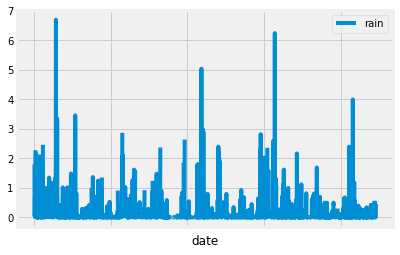

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    
engine.execute('SELECT prcp FROM measurement').fetchall()

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017,8,23)- dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
last_year_data
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame( last_year_data, columns = ["date","rain"])
rain_df.set_index(rain_df["date"],inplace = True)
# Sort the dataframe by date
rain_df = rain_df.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(x_compat = True)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,rain
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
number_station = session.query(func.count(Station.station)).all()
number_station


[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
high_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station =="USC00519281").all()


# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_record= session.query(Measurement.tobs).filter(Measurement.station =="USC00519281").filter(Measurement.date >= last_year).all()
temp_record


![precipitation](Images/station-histogram.png)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#prev_year_start = dt.date(2018,1,1)- dt.timedelta(days=365)
#prev_year_end = dt.date(2018,1,8)- dt.timedelta(days=365)

#tmin,taverage,tmax = calc_temps((prev_year_start), (prev_year_end))

print(calc_temps('2016-01-01', '2016-01-08'))
temps = calc_temps('2016-01-01', '2016-01-08')
temps

[(62.0, 69.91666666666667, 76.0)]


[(62.0, 69.91666666666667, 76.0)]

TypeError: only size-1 arrays can be converted to Python scalars

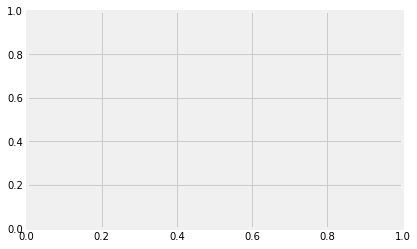

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.bar(3,temps)

In [18]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [22]:
# Plot the daily normals as an area plot with `stacked=False`


In [23]:
from flask import Flask, jsonify
app = Flask(__name__)
import warnings
warnings.filterwarnings('ignore')

In [24]:
app = Flask(__name__)
@app.route("/")
def welcome():
    return (
        f"/api/v1.0/precipitation"
        f"/api/v1.0/stations"
        f"/api/v1.0/tobs"
        f"/api/v1.0/<start>"
        f"/api/v1.0/<start>/<end>"
             )
def percipitation():
    results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
    percipitaion = []
    for rain in results:
        weather_data = {}
        passenger_dict["date"] = passenger.name
        passenger_dict["prcp"] = passenger.age
        percipitaion.append(weather_data)
    return jsonify(all_names)



if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1